In [1]:
import csv
import re
import os
import numpy
import pandas
import itertools
from collections import defaultdict, Counter

In [2]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'png2x'
# %config InlineBackend.figure_format = 'svg'

In [3]:
import spacy
sp = spacy.load('en')

In [4]:
match_filename_6gram = 'match-6gram-20170614.csv'
match_filename_10gram = 'match-20k-10gram-wordlevel-20170406.csv'
match_filename = match_filename_6gram
script_filename = '../../../../original-scripts/force-awakens/force-awakens-markup.txt'
fan_filename_base = '7382338.txt'  # '6165466.txt'
fan_directory = '../../../../fan-works/force-awakens-fullset/english-plaintext/'
browser_directory = '../../../../analysis/reuse/force-awakens-parallel-browsers/'
distance_scale = 5

In [5]:
html_wrapper = """<!DOCTYPE html>
<html>
  <head>
    <meta charset="utf-8">
    <title>{}</title>
    <style>
      #content, html, body {{
          height: 98%;
      }}
      #script {{
          float: left;
          width: 50%;
          height: 100%;
          overflow: scroll;
      }}
      #fanwork {{
          float: left;
          width: 50%;
          height: 100%;
          overflow: scroll;
      }}
      .match.intensity-0 {{
          background-color: rgba(16, 96, 255, 0.65);
      }}
      .match.intensity-1 {{
          background-color: rgba(16, 96, 255, 0.55);
      }}
      .match.intensity-2 {{
          background-color: rgba(16, 96, 255, 0.45);
      }}
      .match.intensity-3 {{
          background-color: rgba(16, 96, 255, 0.35);
      }}
      .match.intensity-4 {{
          background-color: rgba(16, 96, 255, 0.25);
      }}
      .match {{
          background-color: rgba(16, 96, 255, 0.15);
      }}
      .match.selected {{
          background-color: rgba(224, 0, 0, 0.45);
          /* color: rgba(0, 0, 0, 1.0); */
      }}
    </style>
    <script type="text/javascript">
      document.addEventListener('DOMContentLoaded', function() {{
        function align() {{
        
          // Class names encode word-level links; the class
          // is just the attribute ID of the linked word!
          var mid = this.getAttribute('class').match(/(fan|script)-match-\d+/g);
          
          // If a correctly formatted link ID was found...
          if (mid.length > 0) {{
            mid = mid[0];
            var scriptEl, fanEl, offset;
            
            var scriptContainer = document.getElementById('script');
            var fanContainer = document.getElementById('fanwork');

            // Check whether the link is from fan to script
            // or script to fan...
            if (mid.includes('script')) {{
              fanEl = document.getElementById(this.id);
              scriptEl = document.getElementById(mid);
              offset = fanEl.offsetTop - fanContainer.scrollTop;
              scriptContainer.scrollTop = scriptEl.offsetTop - offset;
            }} else {{
              scriptEl = document.getElementById(this.id);
              fanEl = document.getElementById(mid);
              offset = scriptEl.offsetTop - scriptContainer.scrollTop;
              fanContainer.scrollTop = fanEl.offsetTop - offset;

            }}
            
            // Reverse iteration ensures that if the collection
            // is updated (because the selecting class has been
            // removed!) it will not change the order of iteration.
            var oldSelected = document.getElementsByClassName('selected');
            for (var s = oldSelected.length - 1; s >= 0; s -= 1) {{
              oldSelected[s].classList.remove('selected');
            }}
            
            scriptEl.classList.add('selected');
            fanEl.classList.add('selected');
          }}
        }}

        var matches = document.getElementsByClassName('match');
        for (var m = 0; m < matches.length; m += 1) {{
          matches[m].addEventListener('click', align);
        }}
      }});
    </script>
  </head>
  <body>
    <div id="content">
      <div id="script">
        {}
      </div>
      <div id="fanwork">
        {}
      </div>
    </div>
  <script>
  </script>
  </body>
</html>"""

In [6]:
def load_markup_script(filename,
                        _line_rex=re.compile('LINE<<(?P<line>[^>]*)>>'),
                        _scene_rex=re.compile('SCENE_NUMBER<<(?P<scene>[^>]*)>>'),
                        _char_rex=re.compile('CHARACTER_NAME<<(?P<character>[^>]*)>>')):
    with open(filename, encoding='utf-8') as ip:
        current_scene = None
        current_char = None
        current_line = None
        rows = [['LOWERCASE', 'SPACY_ORTH_ID', 'SCENE', 'CHARACTER']]
        for i, line in enumerate(ip):
            if _scene_rex.search(line):
                current_scene = int(_scene_rex.search(line).group('scene'))
            elif _char_rex.search(line):
                current_char = _char_rex.search(line).group('character')
            elif _line_rex.search(line):
                tokens = sp(_line_rex.search(line).group('line'))
                for t in tokens:
                    # original Spacy lexeme object can be recreated using
                    #     spacy.lexeme.Lexeme(sp.vocab, t.orth)
                    # where `sp = spacy.load('en')`
                    row = [t.lower_, t.lower, current_scene, current_char]
                    rows.append(row)
    return rows

def load_fan_work(base):
    if not base.endswith('.txt'):
        base += '.txt'
    fan_filename = fan_directory + base
    with open(fan_filename, encoding='utf-8') as ip:
        return sp(ip.read())
    
def load_matches(match_filename):
    with open(match_filename, encoding='utf-8') as ip:
        return list(csv.reader(ip))

def load_matches_pandas(match_filename):
    return pandas.read_csv('match-6gram-20170614.csv')

def file_getter(match):
    return os.path.split(match[0])[-1]
    
def file_ix_getter(match):
    return (file_getter(match), int(match[1]))
    
def contig_match_map(matches):
    matches = matches[1:]
    matches.sort(key=file_ix_getter)
    m_groups = itertools.groupby(matches, key=file_getter)
    
    match_map = {}
    for fn, m_group in m_groups:
        contig = []
        last = -2
        for m in m_group:
            ix = int(m[1])
            if int(ix) != last + 1:
                contig.append([m])
            else:
                contig[-1].append(m)
            last = ix
    
        match_map[fn] = contig

    return match_map

def contig_match_map_merged(matches, n):
    match_map = contig_match_map(matches)
    for fn in match_map:
        match_map[fn] = [c
                         for contig in match_map[fn]
                         for c in merge_contig(contig, n)]
    return match_map

def contig_match_map_merged_no_overlap(matches, n):
    match_map = contig_match_map(matches)
    for fn in match_map:
        match_map[fn] = [merge_contig(contig, n)[0]
                         for contig in match_map[fn]]
    return match_map
    
def merge_contig(contig, n):
    merged = []
    n_matches = 1 + len(contig) - n
    for i in range(n_matches):
        newmatch = contig[i][:]
        fan_ngram = ' '.join(contig[i + j][2] for j in range(n))
        script_ngram = ' '.join(contig[i + j][5] for j in range(n))
        newmatch[2] = fan_ngram
        newmatch[5] = script_ngram
        merged.append(newmatch)
    return merged

def fan_match_html(matches, fan):
    match_dict = defaultdict(list)
    for m in matches:
        match_dict[int(m[1])].append(m)
    for i, w in enumerate(fan):
        if i in match_dict:
            best_match = min(match_dict[i], key=lambda m: float(m[-1]))
            match_from = i
            match_to = int(best_match[4])
            distance = round(float(best_match[-1]), 3)
            intensity = int(distance_scale * distance)
            yield _span_template.format('fan', 
                                        match_from, 
                                        'script', 
                                        match_to, 
                                        intensity, 
                                        distance, 
                                        str(w))

        else:
            yield str(w) + ' '

def render_parallel_html_browser(matches, script, fan_filename_base):
    matches = query_matches(matches, fan_filename_base)
    fan_work = load_fan_work(fan_filename_base)
    fan_filename_html = fan_filename_base.replace('.txt', '.html')
    
    script_html = ''.join(script_match_html(matches, script))
    fan_html = ''.join(fan_match_html(matches, fan_work))
    html = html_wrapper.format(
        fan_filename_base,
        script_html.replace('\n', '<br/>'),
        fan_html.replace('\n', '<br/>')
    )
    
    with open(browser_directory + fan_filename_html, 
              'w', encoding='utf-8') as op:
        op.write(html)

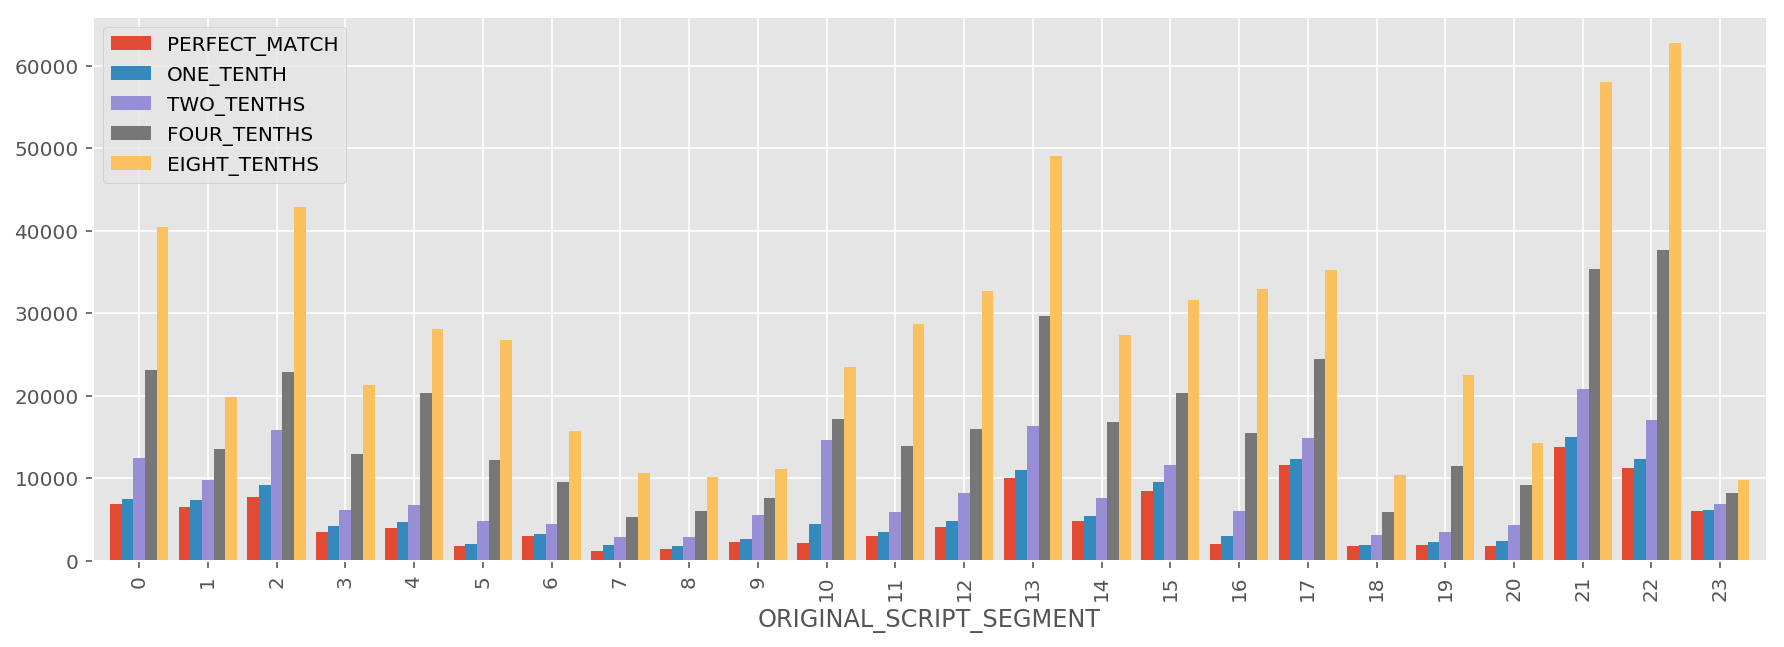

In [7]:
matches = load_matches_pandas(match_filename)
thresh_names = [(0.0001, 'PERFECT_MATCH'),
                (0.1, 'ONE_TENTH'),
                (0.2, 'TWO_TENTHS'),
                (0.4, 'FOUR_TENTHS'),
                (0.8, 'EIGHT_TENTHS')]
for thresh, name in thresh_names:
    match_result = matches.BEST_COMBINED_DISTANCE < thresh
    matches = matches.assign(**{name: match_result})

segments = matches.ORIGINAL_SCRIPT_WORD_INDEX // 400
matches = matches.assign(ORIGINAL_SCRIPT_SEGMENT=segments)

subsegments = matches.ORIGINAL_SCRIPT_WORD_INDEX // 40
matches = matches.assign(ORIGINAL_SCRIPT_SUBSEGMENT=subsegments)

segment_groups = matches.groupby(
    'ORIGINAL_SCRIPT_SEGMENT'
).aggregate({
    name: numpy.sum for _th, name in thresh_names
})

plt = segment_groups.plot.bar(figsize=(15, 5), width=0.85)

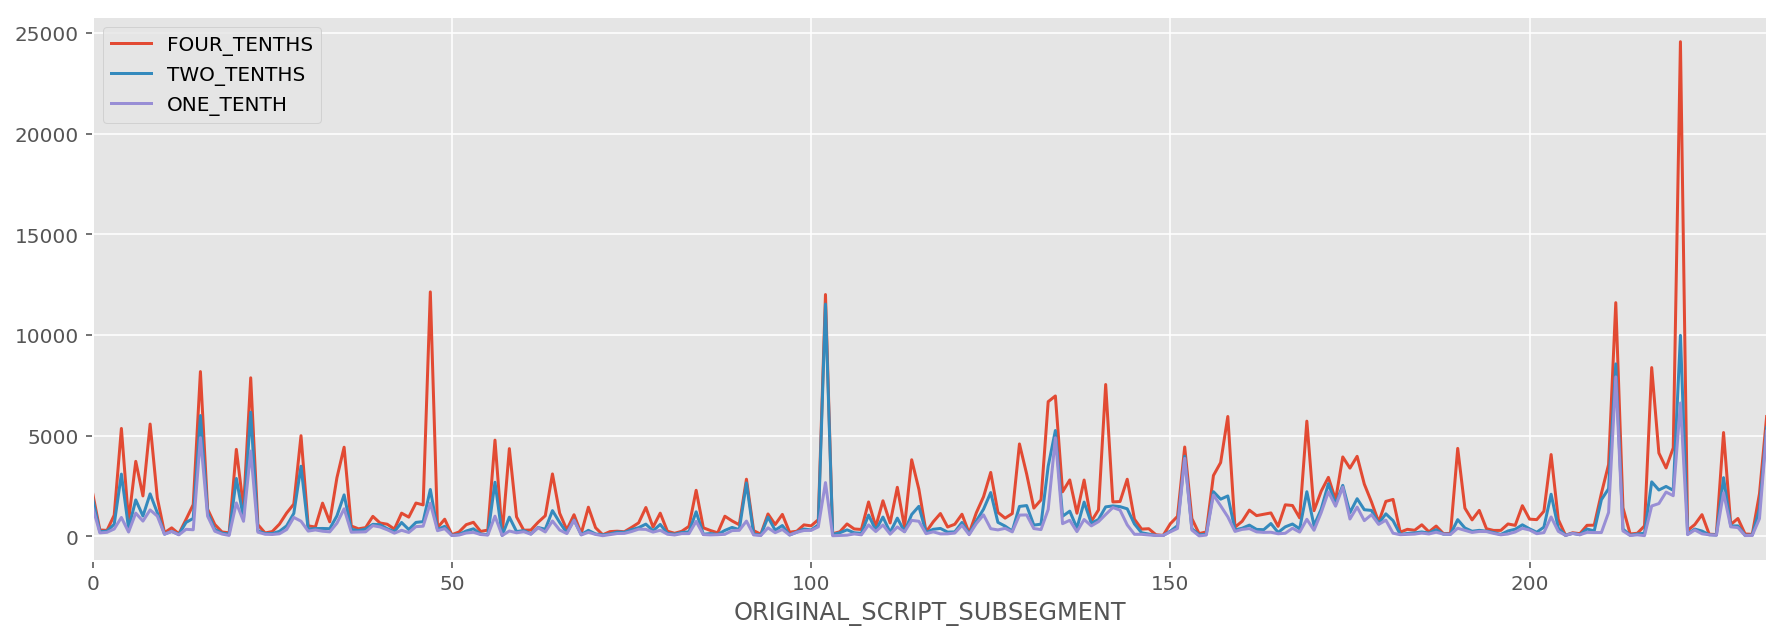

In [8]:
subsegment_groups = matches.groupby(
    'ORIGINAL_SCRIPT_SUBSEGMENT'
).aggregate({
    name: numpy.sum for _th, name in thresh_names[3:0:-1]
})

plt = subsegment_groups.plot(figsize=(15, 5))

In [ ]:
# matches = load_matches(match_filename)
# # match_map = contig_match_map_merged_no_overlap(matches, 6)
# match_map = contig_match_map_merged(matches, 6)
# script = load_markup_script(script_filename)[1:]

# top_reusers = Counter({fn: len(m) for fn, m in match_map.items()})
# top_reusers = top_reusers.most_common(50)
# print(top_reusers)
# top_reusers_2 = [('7382338.txt', 1672), ('5660062.txt', 970), ('6396253.txt', 803), 
#                ('5695981.txt', 716), ('5765002.txt', 511), ('5894128.txt', 367), 
#                ('5608165.txt', 366), ('8142448.txt', 344), ('8242133.txt', 344), 
#                ('6487681.txt', 322), ('7568425.txt', 294), ('6876964.txt', 291), 
#                ('5709586.txt', 276), ('7570435.txt', 261), ('5926093.txt', 259), 
#                ('7570705.txt', 255), ('5663341.txt', 241), ('5989575.txt', 214), 
#                ('6101911.txt', 205), ('5668453.txt', 200), ('6864859.txt', 196), 
#                ('9249833.txt', 194), ('5620315.txt', 192), ('8574436.txt', 192), 
#                ('6487381.txt', 189), ('5789281.txt', 186), ('6740008.txt', 186), 
#                ('5809261.txt', 184), ('7364140.txt', 180), ('5738035.txt', 179), 
#                ('5504096.txt', 174), ('7329643.txt', 172), ('5871907.txt', 170), 
#                ('6359890.txt', 168), ('6572161.txt', 162), ('6165466.txt', 160), 
#                ('6585115.txt', 159), ('9254591.txt', 159), ('7571068.txt', 157), 
#                ('6143874.txt', 155), ('6726715.txt', 155), ('6472714.txt', 154), 
#                ('7442263.txt', 151), ('5528261.txt', 150), ('6939529.txt', 149), 
#                ('5827186.txt', 148), ('6886216.txt', 140), ('6748732.txt', 139), 
#                ('6989956.txt', 136), ('5663299.txt', 134)]
# print(len({f for f, c in top_reusers} - {f for f, c in top_reusers_2}))
# print(len({f for f, c in top_reusers_2} - {f for f, c in top_reusers}))

In [ ]:
# for fn, count in top_reusers:
#     render_parallel_html_browser(matches, script, fn)